In [1]:
import tensorflow_hub as hub
import tensorflow_text as text

In [30]:
preprocess_url = 'https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3'
encoder_url = 'https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-10-h-128-a-2/versions/2'

In [5]:
import pandas as pd

df = pd.read_csv('/kaggle/input/spam-email/spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [9]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

# Handle imbalance data
15% spam and 85% ham

In [11]:
df_spam = df[df['Category'] == 'spam']
df_ham = df[df['Category'] == 'ham']

df_ham_downsampled = df[df['Category'] == 'ham'].sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [12]:
df_balanced = pd.concat([df_spam, df_ham_downsample])
df_balanced.shape

(1494, 2)

In [16]:
# add 'spam' column with value 1-spam, 0-ham
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
1784,ham,No dear i do have free messages without any re...,0
3642,spam,"You can stop further club tones by replying ""S...",1
5285,spam,URGENT! You have won a 1 week FREE membership ...,1
4611,ham,Just glad to be talking to you.,0
756,ham,So why didnt you holla?,0


In [37]:
from sklearn.model_selection import train_test_split

X = df_balanced['Message']
y = df_balanced['spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

X_train.shape

(1195,)

# Using Bert to get embedding vectors for few samples

In [20]:
bert_preprocessor = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url, trainable=False)

def get_sentence_embeddings(sentences):
    preprocessed_text = bert_preprocessor(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeddings([
    'i want to buy this car',
    'u got me'
])

<tf.Tensor: shape=(2, 128), dtype=float32, numpy=
array([[-0.9935151 ,  0.99872196,  0.03449824, -0.9805651 , -0.99684626,
         0.45935857, -0.39093506,  0.04058843,  0.9947196 , -0.92951477,
        -0.6307559 ,  0.7581157 ,  0.9223333 ,  0.8147735 , -0.0203024 ,
         0.9261019 , -0.988836  ,  0.60886943, -0.81888276,  0.97744954,
        -0.9765734 , -0.07743584, -0.86471087,  0.9715284 , -0.76274705,
         0.82926637, -0.7497604 , -0.9957475 ,  0.11327456, -0.9407009 ,
         0.99713147,  0.99680465,  0.888358  ,  0.7296535 ,  0.9664351 ,
        -0.12197501, -0.66284394, -0.66229546,  0.69827473,  0.18736376,
        -0.9916199 , -0.72286516,  0.0496996 ,  0.9991246 , -0.9671554 ,
        -0.9257339 , -0.09916823, -0.68199533,  0.90247846,  0.9981935 ,
        -0.758637  , -0.79500395,  0.37762845, -0.6122527 , -0.06389429,
        -0.8708437 ,  0.18063469,  0.15303865, -0.9815207 ,  0.64359933,
        -0.9988296 ,  0.10668136, -0.25224325,  0.09464911, -0.9280907 ,
 

# Get embedding vectors for few sample words and using Cosine-similarity to compare them

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

e = get_sentence_embeddings([
    'hello',
    'hi',
    'goodbye',
    'football',
    'baseball'
])
print('hello vs hi: ', cosine_similarity([e[0]], [e[1]]))
print('hello vs goodbye: ', cosine_similarity([e[0]], [e[2]]))
print('hello vs football: ', cosine_similarity([e[0]], [e[3]]))

hello vs hi:  [[0.975988]]
hello vs goodbye:  [[0.98717976]]
hello vs football:  [[0.79031503]]


# Build model

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout

# Bert layer
text_input = Input(shape=(), dtype=tf.string)
preprocessed_text = bert_preprocessor(text_input)
text_output = bert_encoder(preprocessed_text)['pooled_output']

# Neural network layers
x = Dense(128, activation='relu')(text_output)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[text_input], outputs=[x])

In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_2 (KerasLayer)  {'input_word_ids': (None,    0         ['input_5[0][0]']             
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                              

In [34]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='acc'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=METRICS)

In [35]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
38/38 [==============================] - 25s 411ms/step - loss: 0.4619 - acc: 0.7866 - precision: 0.7952 - recall: 0.7726
Epoch 2/10
38/38 [==============================] - 16s 411ms/step - loss: 0.2768 - acc: 0.8904 - precision: 0.8712 - recall: 0.9164
Epoch 3/10
38/38 [==============================] - 15s 404ms/step - loss: 0.2559 - acc: 0.9021 - precision: 0.8848 - recall: 0.9247
Epoch 4/10
38/38 [==============================] - 16s 416ms/step - loss: 0.2293 - acc: 0.9105 - precision: 0.8979 - recall: 0.9264
Epoch 5/10
38/38 [==============================] - 15s 406ms/step - loss: 0.2191 - acc: 0.9163 - precision: 0.9016 - recall: 0.9348
Epoch 6/10
38/38 [==============================] - 16s 408ms/step - loss: 0.2098 - acc: 0.9197 - precision: 0.9128 - recall: 0.9281
Epoch 7/10
38/38 [==============================] - 15s 404ms/step - loss: 0.1987 - acc: 0.9222 - precision: 0.9079 - recall: 0.9398
Epoch 8/10
38/38 [==============================] - 15s 393ms/step - 

In [38]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 5s 382ms/step - loss: 0.2060 - acc: 0.9264 - precision: 0.9045 - recall: 0.9530


[0.2059604674577713,
 0.9264214038848877,
 0.9044585824012756,
 0.9530201554298401]

In [43]:
import numpy as np

y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

10/10 [==============================] - 4s 389ms/step


array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0])

Text(50.722222222222214, 0.5, 'Truth')

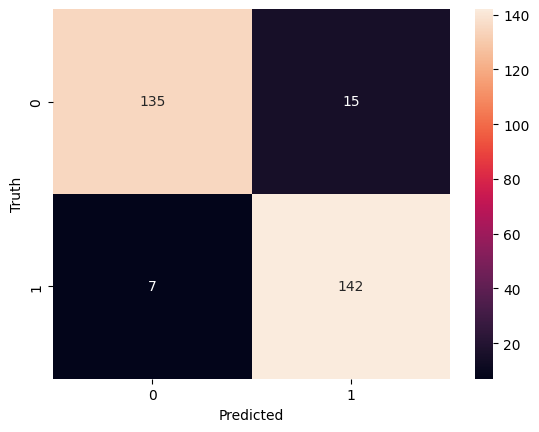

In [44]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn

cm = confusion_matrix(y_test, y_predicted)

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [45]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       150
           1       0.90      0.95      0.93       149

    accuracy                           0.93       299
   macro avg       0.93      0.93      0.93       299
weighted avg       0.93      0.93      0.93       299

